<h1>Import frameworks</h1>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader


#gpu_device = torch.device("cpu")
#if torch.backends.mps.is_available():
#    gpu_device = torch.device("mps")
#else:
#    print ("MPS device not found.")

<h1>Import datasets</h1>

In [2]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='Assignment6/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='Assignment6/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))



train dataset:  60000
test dataset:  10000


<h1>Plot images</h1>

In [ ]:

for images, labels in train_loader:
    print("Image shape:", images.size())
    print("Label shape:", labels.size()) 

    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    plt.savefig('mnist_images.png', bbox_inches='tight')
    break  


<h1>Neural Network</h1>

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU except for the last layer
                layers.append(nn.ReLU())


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)

<h1>Training</h1>

In [3]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs, name):
    train_losses = []  
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for images, labels in train_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        for images, labels in test_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    ax.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Losses')
    ax.legend()
    plt.show()
    fig.savefig(name  +  ".pdf", bbox_inches='tight')


<h1>Single hidden layer</h1>

In [ ]:
input_size = 28 * 28 
hidden_sizes = [500] # Is this the best choice?
output_size = 10  

model = NeuralNet(input_size, hidden_sizes, output_size)
#model = model.to(gpu_device)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "single_hidden_layer")

<h1>Two hidden layer</h1>

In [ ]:
input_size = 28 * 28   
hidden_sizes = [500, 300]  
output_size = 10  
weight_decay = 0.01
model = NeuralNet(input_size, hidden_sizes, output_size)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "two_hidden_layer")



<h1>Convolutional neural network</h1>

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


<h1>Train convolutional neural network</h1>

Epoch [1/40], Training Loss: 0.5129, Test Loss: 0.0877
Epoch [2/40], Training Loss: 0.1380, Test Loss: 0.0768
Epoch [3/40], Training Loss: 0.1254, Test Loss: 0.0788
Epoch [4/40], Training Loss: 0.1200, Test Loss: 0.0544
Epoch [5/40], Training Loss: 0.1201, Test Loss: 0.0588
Epoch [6/40], Training Loss: 0.1168, Test Loss: 0.0768
Epoch [7/40], Training Loss: 0.1146, Test Loss: 0.0763
Epoch [8/40], Training Loss: 0.1166, Test Loss: 0.0697
Epoch [9/40], Training Loss: 0.1152, Test Loss: 0.0590
Epoch [10/40], Training Loss: 0.1155, Test Loss: 0.0851
Epoch [11/40], Training Loss: 0.1142, Test Loss: 0.1165
Epoch [12/40], Training Loss: 0.1160, Test Loss: 0.0713
Epoch [13/40], Training Loss: 0.1139, Test Loss: 0.0842
Epoch [14/40], Training Loss: 0.1179, Test Loss: 0.0698
Epoch [15/40], Training Loss: 0.1142, Test Loss: 0.0711
Epoch [16/40], Training Loss: 0.1166, Test Loss: 0.0761
Epoch [17/40], Training Loss: 0.1124, Test Loss: 0.0722
Epoch [18/40], Training Loss: 0.1136, Test Loss: 0.0838
E

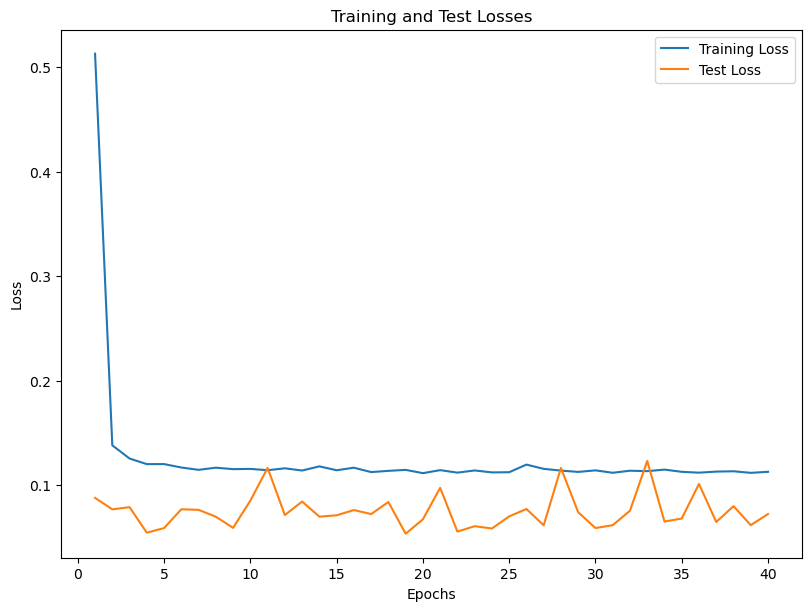

In [6]:

model = CNN2() #CNN()

weight_decay = 0.01
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "cnn")

In [ ]:


conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Create a random input tensor
x = torch.randn(32, 1, 28, 28)  # Batch size of 32, 1 channel, 28x28 image




print("Output:", x.size())
x = conv1(x)
print("Output after conv1:", x.size())
x = conv2(x)
print("Output after conv2:", x.size())
x = conv3(x)
print("Output after conv3:", x.size())
x = pool(x)
print("Output after pool1:", x.size())
x = pool(x)
print("Output after pool2:", x.size())
x = pool(x)
print("Output after pool3:", x.size())

